# Analysis of SASSIE Play 1 


In [1]:
import cftime 
from datetime import datetime, timedelta
import cartopy
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors
from math import radians, cos, sin, asin, sqrt
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy import io
from scipy import stats
from scipy import signal

%matplotlib widget

In [2]:
# Load Play 1 SWIFT data
# Create variables to store all data from different SWIFTs
time = []
latitude = []
longitude = []
hs_wave = []
wave_direction = []
wave_period = []
drift_speed = []
drift_direction = []
instrument_type = []
windspd = []
winddir = []
swiftnum = []

swift_fnames = ['../swift-data/SASSIE_Fall_2022_SWIFT12_play1.nc', '../swift-data/SASSIE_Fall_2022_SWIFT13_play1.nc', 
                '../swift-data/SASSIE_Fall_2022_SWIFT15_play1.nc', '../swift-data/SASSIE_Fall_2022_SWIFT16_play1.nc', 
                '../swift-data/SASSIE_Fall_2022_SWIFT17_play1.nc']

for fname in swift_fnames:
    swift_data = nc.Dataset(fname)

    # Save the variables from each SWIFT file to new list
    time.append(cftime.num2pydate(swift_data['time'][:], units=swift_data['time'].units))
    latitude.append(swift_data['latitude'][:])
    longitude.append(swift_data['longitude'][:])
    hs_wave.append(swift_data['surface_wave_height'][:])
    wave_direction.append(swift_data['surface_wave_direction'][:])
    wave_period.append(swift_data['surface_wave_period'][:])
    drift_speed.append(swift_data['drift_speed'][:])
    drift_direction.append(swift_data['drift_direction'][:])
    instrument_type.append(['SWIFT' for n in range(swift_data['drift_direction'][:].size)])
    windspd.append(swift_data['wind_speed'][:])
    winddir.append(swift_data['wind_direction'][:])
    swiftnum.append(int(fname[36:38])*np.ones(swift_data['wind_direction'][:].size))

    # Close the nc file
    swift_data.close()

wave_glider_names = ['../L1/WaveGliders_L1/SV3-130_L1.mat', '../L1/WaveGliders_L1/SV3-153_L1.mat', 
                     '../L1/WaveGliders_L1/SV3-245_L1.mat', '../L1/WaveGliders_L1/SV3-247_L1.mat']

def get_wg_data(variable):
    data = wg_data['SV3'][variable].squeeze()
    data = np.concatenate(data).flatten()
    return data

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

for fname in wave_glider_names:
    wg_data = io.loadmat(fname)
    # Save the variables from each SWIFT file to new list
    time_datenum = get_wg_data('time')
    time_datetime = [datenum_to_datetime(time_datenum[n]) for n in range(time_datenum.size)]
    time.append(time_datetime)
    latitude.append(get_wg_data('lat'))
    longitude.append(get_wg_data('lon'))
    hs_wave.append(get_wg_data('sigwaveheight'))
    wave_direction.append(np.NaN*np.ones(get_wg_data('lat').size))
    drift_speed.append(np.NaN*np.ones(get_wg_data('lat').size))
    drift_direction.append(np.NaN*np.ones(get_wg_data('lat').size))
    instrument_type.append(['WG' for n in range(get_wg_data('lat').size)])
    windspd.append(get_wg_data('windspd'))
    winddir.append(get_wg_data('winddirT'))
    swiftnum.append(np.NaN*np.ones(get_wg_data('lat').size))
    wave_period.append(np.NaN*np.ones(get_wg_data('lat').size))
    

# Concatenate and flatten the aggregate data
time = np.concatenate(time).flatten()
latitude = np.concatenate(latitude).flatten()
longitude = np.concatenate(longitude).flatten()
hs_wave = np.concatenate(hs_wave).flatten()
wave_direction = np.concatenate(wave_direction).flatten()
wave_period = np.concatenate(wave_period).flatten()
drift_speed = np.concatenate(drift_speed).flatten()
drift_direction = np.concatenate(drift_direction).flatten()
instrument_type = np.concatenate(instrument_type).flatten()
windspd = np.concatenate(windspd).flatten()
winddir = np.concatenate(winddir).flatten()
swiftnum = np.concatenate(swiftnum).flatten()

# Compute the Distance from each measurement to the ice edge
def compute_dist_to_ice_edge(lats, ice_edge_lat):
    dist_to_ice_edge = np.zeros(lats.size)
    
    for n in range(lats.size):
        # Basic calculation 
        diff = ice_edge_lat - lats[n]
        dist_to_ice_edge[n] = diff * 111 # 111 km per degree of lat

    return dist_to_ice_edge

# Compute the distance to ice edge for each measurement
ice_edge_lat = 72.4
dist_to_ice_edge_measured = compute_dist_to_ice_edge(latitude, ice_edge_lat)

# Create Pandas Dataframe to aggregate the SWIFT data
df = pd.DataFrame(time, columns=['time'])
df['latitude'] = latitude
df['longitude'] = longitude
df['hs'] = hs_wave
df['wave_direction'] = wave_direction
df['wave_direction_mathconv'] = 270 - wave_direction
df['drift_speed'] = drift_speed
df['drift_direction'] = drift_direction
df['instrument_type'] = instrument_type
df['dist_to_ice_edge'] = dist_to_ice_edge_measured
df['windspd'] = windspd
df['winddir'] = winddir
df['swiftnum'] = swiftnum
df['winddir_mathconv'] = 270 - winddir
df['wave_period'] = wave_period

# Fill all -999 with NaN values
df.replace(to_replace=-999, value=np.NaN, inplace=True)

# trim the dataframe to be just within play 1
mask = (df['time'] > '2022-09-09 21:00:00') & (df['time'] <= '2022-09-10 12:00:00')
df = df.loc[mask]

# Print the df
df

,time,latitude,longitude,hs,wave_direction,wave_direction_mathconv,drift_speed,drift_direction,instrument_type,dist_to_ice_edge,windspd,winddir,swiftnum,winddir_mathconv,wave_period
0,2022-09-09 21:24:00.000004,72.586037,-149.964966,0.815253,52.389679,217.610321,NaN,NaN,SWIFT,-20.650072,9.851455,39.118851,12.0,230.881149,2.039841
1,2022-09-09 21:36:00.000002,72.587006,-149.976730,0.939075,49.847000,220.153000,0.554840,285.247159,SWIFT,-20.757623,10.378298,43.066589,12.0,226.933411,1.946768
2,2022-09-09 21:48:00.000000,72.587936,-149.988266,0.945042,80.848877,189.151123,0.554722,286.136217,SWIFT,-20.860941,10.409463,47.654869,12.0,222.345131,2.142259
3,2022-09-09 21:59:59.999996,72.589012,-149.999924,0.934823,110.630768,159.369232,0.565919,287.676971,SWIFT,-20.980348,10.356704,42.467369,12.0,227.532631,2.860335
4,2022-09-09 22:12:00.000004,72.590172,-150.011734,0.977387,104.254364,165.745636,0.581481,289.020320,SWIFT,-21.109071,10.136875,44.359627,12.0,225.640373,3.065868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,2022-09-10 10:00:00.000007,72.050569,-149.414291,3.117780,NaN,NaN,NaN,NaN,WG,38.786853,11.185567,76.300000,NaN,193.700000,NaN
9068,2022-09-10 10:30:00.000000,72.055220,-149.392666,3.162674,NaN,NaN,NaN,NaN,WG,38.270566,10.670103,72.000000,NaN,198.000000,NaN
9069,2022-09-10 11:00:00.000003,72.060844,-149.369176,3.050994,NaN,NaN,NaN,NaN,WG,37.646312,10.463918,80.700000,NaN,189.300000,NaN
9070,2022-09-10 11:30:00.000007,72.067396,-149.344267,3.168890,NaN,NaN,NaN,NaN,WG,36.918993,10.670103,93.300000,NaN,176.700000,NaN


In [3]:
swift_data = nc.Dataset('../swift-data/SASSIE_Fall_2022_SWIFT12_play1.nc')
swift_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    DOI: 10.5067/SASSIE-SWIFT2
    title: SASSIE Arctic Field Campaign SWIFT Data Fall 2022
    summary: Data collected from Surface Wave Instrument Float with Tracking (SWIFT)12.  See www.apl.uw.edu/SWIFT for more information
    keywords: EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE > TEMPERATURE PROFILES, EARTH SCIENCE > OCEANS > SALINITY/DENSITY > SALINITY PROFILES, EARTH SCIENCE > OCEANS > SALINITY/DENSITY > CONDUCTIVITY PROFILES, EARTH SCIENCE > OCEANS > OCEAN CIRCULATION > CURRENT VELOCITY, EARTH SCIENCE > OCEANS > OCEAN CIRCULATION > OCEAN CURRENTS > CURRENT PROFILES, EARTH SCIENCE > OCEANS > OCEAN WINDS > SURFACE WINDS, EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC TEMPERATURE > AIR TEMPERATURE, EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC PRESSURE > ATMOSPHERIC PRESSURE MEASUREMENTS
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    conventions: CF-1.8, ACDD-1.3
  

In [4]:
test = '../swift-data/SASSIE_Fall_2022_SWIFT12_play1.nc'
int(test[36:38])


12

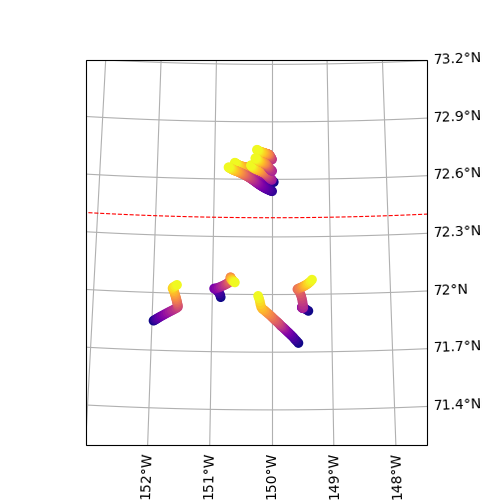

In [5]:
# Plot locations of the SWIFTs
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
ax.scatter(df['longitude'], df['latitude'], c=df['time'], cmap='plasma', transform=cartopy.crs.PlateCarree())

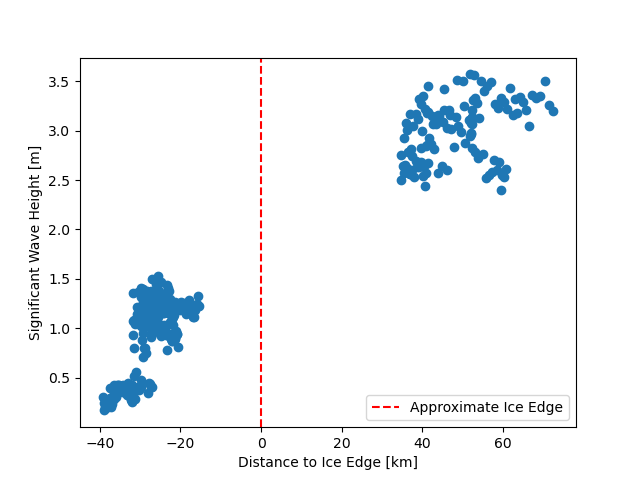

In [6]:
# Plot the wave height as a function of the distance to ice edge for each day
fig, ax = plt.subplots()
ax.scatter(df['dist_to_ice_edge'], df['hs'])
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

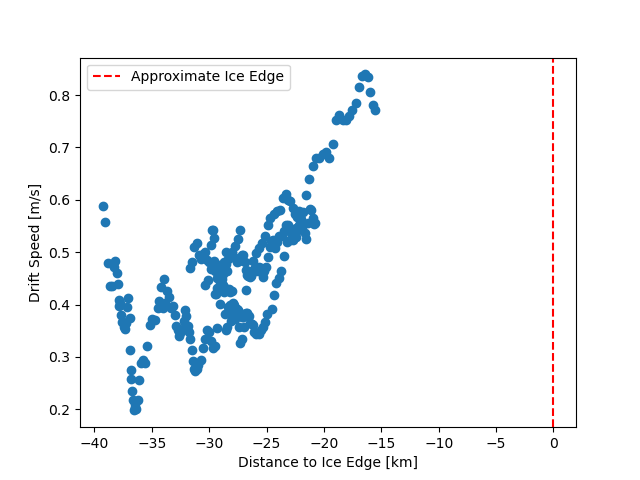

In [25]:
# Plot the drift speed a function of the 
fig, ax = plt.subplots()
ax.scatter(df['dist_to_ice_edge'], df['drift_speed'])
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

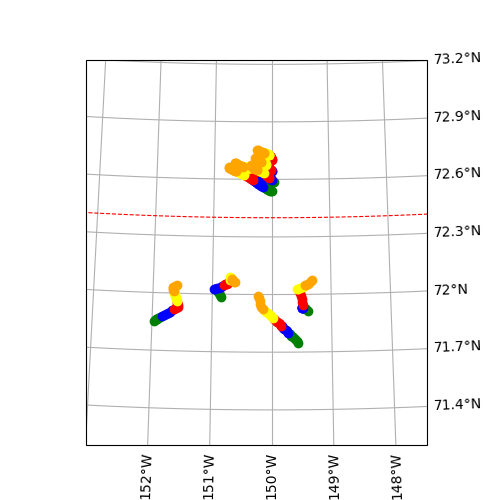

In [7]:
# Subset Dataframe to each day of deployment
# 3 hour windows
# window 1 df
mask = (df['time'] > '2022-09-09 21:00:00') & (df['time'] <= '2022-09-10 00:00:00')
window1_df = df.loc[mask]

# window 2 df
mask = (df['time'] > '2022-09-10 00:00:00') & (df['time'] <= '2022-09-10 03:00:00')
window2_df = df.loc[mask]

# window 3 df
mask = (df['time'] > '2022-09-10 03:00:00') & (df['time'] <= '2022-09-10 06:00:00')
window3_df = df.loc[mask]

# window 4 df
mask = (df['time'] > '2022-09-10 06:00:00') & (df['time'] <= '2022-09-10 09:00:00')
window4_df = df.loc[mask]

# window 5 df
mask = (df['time'] > '2022-09-10 09:00:00') & (df['time'] <= '2022-09-10 12:00:00')
window5_df = df.loc[mask]

# Plot each Window
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = False
gridlines.right_labels = True

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[72.4], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
ax.scatter(window1_df['longitude'], window1_df['latitude'], color='green', transform=cartopy.crs.PlateCarree())
ax.scatter(window2_df['longitude'], window2_df['latitude'], color='blue', transform=cartopy.crs.PlateCarree())
ax.scatter(window3_df['longitude'], window3_df['latitude'], color='red', transform=cartopy.crs.PlateCarree())
ax.scatter(window4_df['longitude'], window4_df['latitude'], color='yellow', transform=cartopy.crs.PlateCarree())
ax.scatter(window5_df['longitude'], window5_df['latitude'], color='orange', transform=cartopy.crs.PlateCarree())

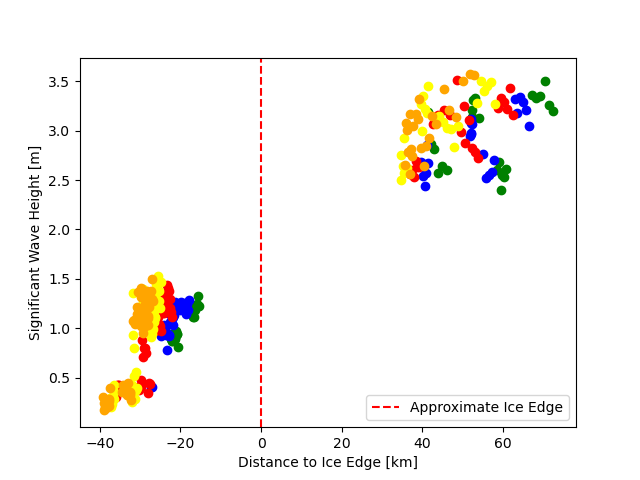

In [8]:
# Plot the wave height as a function of the distance to ice edge for each day
fig, ax = plt.subplots()
ax.scatter(window1_df['dist_to_ice_edge'], window1_df['hs'], color='green')
ax.scatter(window2_df['dist_to_ice_edge'], window2_df['hs'], color='blue')
ax.scatter(window3_df['dist_to_ice_edge'], window3_df['hs'], color='red')
ax.scatter(window4_df['dist_to_ice_edge'], window4_df['hs'], color='yellow')
ax.scatter(window5_df['dist_to_ice_edge'], window5_df['hs'], color='orange')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

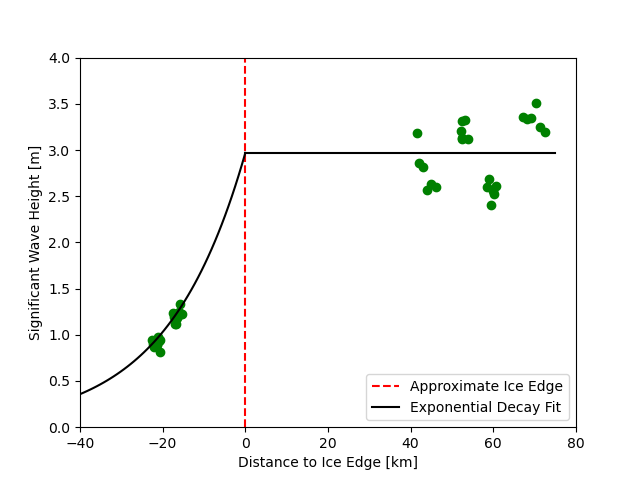

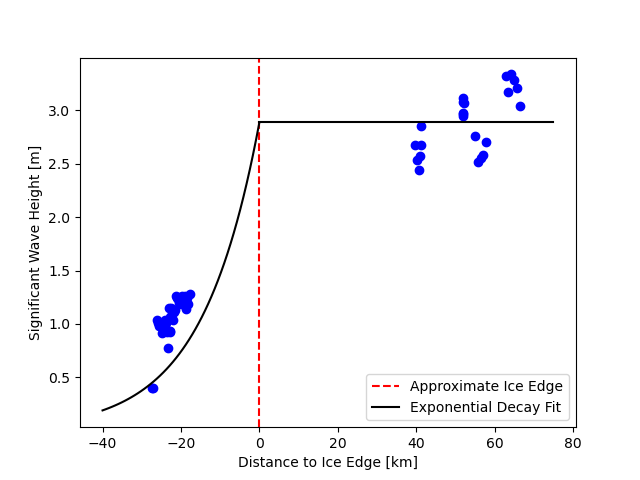

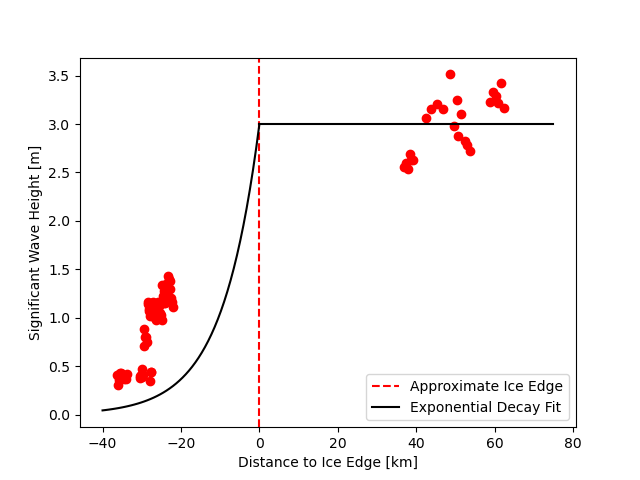

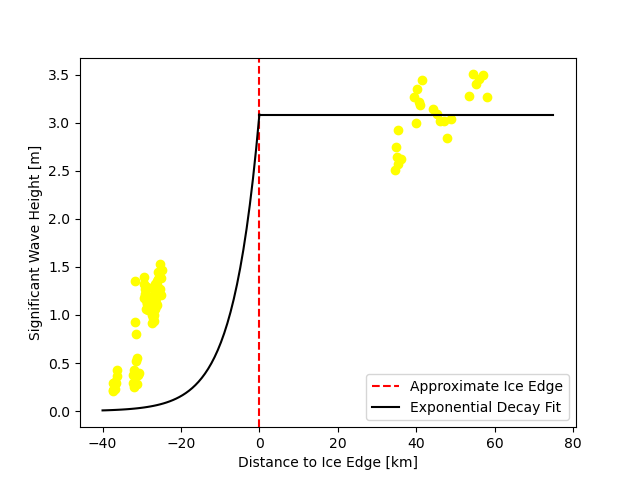

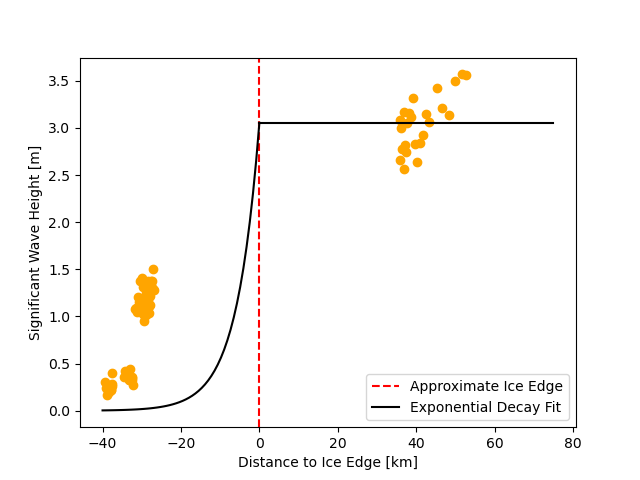

In [30]:
# Exponential decay fit to each window
# Window 1
H0 = np.nanmean(window1_df['hs'].loc[window1_df['dist_to_ice_edge'] > 0])
regress_results = stats.linregress(window1_df['dist_to_ice_edge'].loc[window1_df['dist_to_ice_edge'] < 0], np.log(H0) - np.log(window1_df['hs'].loc[window1_df['dist_to_ice_edge'] < 0]))
alpha = regress_results.slope

fig, ax = plt.subplots()
ax.scatter(window1_df['dist_to_ice_edge'], window1_df['hs'], color='green')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.plot(np.linspace(-40, 0), H0 * np.exp(-alpha*np.linspace(-40, 0)), color='k', label='Exponential Decay Fit')
ax.plot([0, 75], [H0, H0], color='k')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()
ax.set_xlim(-40, 80)
ax.set_ylim(0, 4)

# Window 2
H0_window2 = np.nanmean(window2_df['hs'].loc[window2_df['dist_to_ice_edge'] > 0])
regress_results_window2 = stats.linregress(window2_df['dist_to_ice_edge'].loc[window2_df['dist_to_ice_edge'] < 0], np.log(H0) - np.log(window2_df['hs'].loc[window2_df['dist_to_ice_edge'] < 0]))
alpha_window2 = regress_results_window2.slope

fig, ax = plt.subplots()
ax.scatter(window2_df['dist_to_ice_edge'], window2_df['hs'], color='blue')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.plot(np.linspace(-40, 0), H0_window2 * np.exp(-alpha_window2*np.linspace(-40, 0)), color='k', label='Exponential Decay Fit')
ax.plot([0, 75], [H0_window2, H0_window2], color='k')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

# Window 3
H0_window3 = np.nanmean(window3_df['hs'].loc[window3_df['dist_to_ice_edge'] > 0])
regress_results_window3 = stats.linregress(window3_df['dist_to_ice_edge'].loc[window3_df['dist_to_ice_edge'] < 0], np.log(H0) - np.log(window3_df['hs'].loc[window3_df['dist_to_ice_edge'] < 0]))
alpha_window3 = regress_results_window3.slope

fig, ax = plt.subplots()
ax.scatter(window3_df['dist_to_ice_edge'], window3_df['hs'], color='red')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.plot(np.linspace(-40, 0), H0_window3 * np.exp(-alpha_window3*np.linspace(-40, 0)), color='k', label='Exponential Decay Fit')
ax.plot([0, 75], [H0_window3, H0_window3], color='k')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

# Window 4
H0_window4 = np.nanmean(window4_df['hs'].loc[window4_df['dist_to_ice_edge'] > 0])
window4_nonan_df = window4_df.dropna()
regress_results_window4 = stats.linregress(window4_nonan_df['dist_to_ice_edge'].loc[window4_nonan_df['dist_to_ice_edge'] < 0], np.log(H0) - np.log(window4_nonan_df['hs'].loc[window4_nonan_df['dist_to_ice_edge'] < 0]))
alpha_window4 = regress_results_window4.slope

fig, ax = plt.subplots()
ax.scatter(window4_df['dist_to_ice_edge'], window4_df['hs'], color='yellow')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.plot(np.linspace(-40, 0), H0_window4 * np.exp(-alpha_window4*np.linspace(-40, 0)), color='k', label='Exponential Decay Fit')
ax.plot([0, 75], [H0_window4, H0_window4], color='k')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

# Window 5
H0_window5 = np.nanmean(window5_df['hs'].loc[window5_df['dist_to_ice_edge'] > 0])

regress_results_window5 = stats.linregress(window5_df['dist_to_ice_edge'].loc[window5_df['dist_to_ice_edge'] < 0], np.log(H0) - np.log(window5_df['hs'].loc[window5_df['dist_to_ice_edge'] < 0]))
alpha_window5 = regress_results_window5.slope

fig, ax = plt.subplots()
ax.scatter(window5_df['dist_to_ice_edge'], window5_df['hs'], color='orange')
ax.axvline(0, color='r', linestyle='dashed', label='Approximate Ice Edge')
ax.plot(np.linspace(-40, 0), H0_window5 * np.exp(-alpha_window5*np.linspace(-40, 0)), color='k', label='Exponential Decay Fit')
ax.plot([0, 75], [H0_window5, H0_window5], color='k')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

Text(0, 0.5, 'Drift Speed [m/s]')

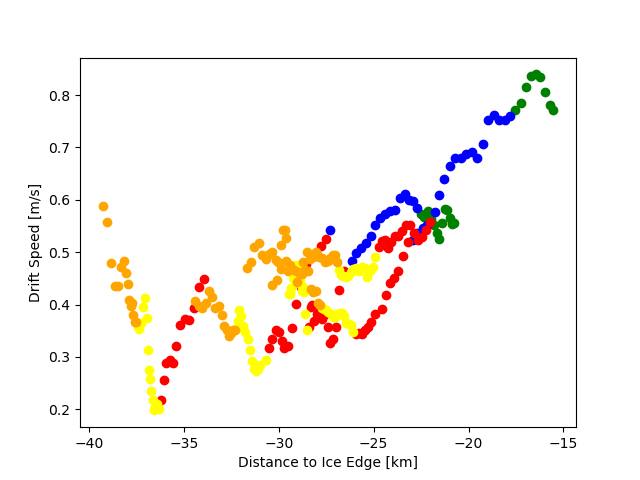

In [10]:
# Plot the drift speed as a function of the distance to ice edge for each day
fig, ax = plt.subplots()
ax.scatter(window1_df['dist_to_ice_edge'], window1_df['drift_speed'], color='green')
ax.scatter(window2_df['dist_to_ice_edge'], window2_df['drift_speed'], color='blue')
ax.scatter(window3_df['dist_to_ice_edge'], window3_df['drift_speed'], color='red')
ax.scatter(window4_df['dist_to_ice_edge'], window4_df['drift_speed'], color='yellow')
ax.scatter(window5_df['dist_to_ice_edge'], window5_df['drift_speed'], color='orange')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Drift Speed [m/s]')

Text(0, 0.5, 'Drift Direction [degrees from True North]')

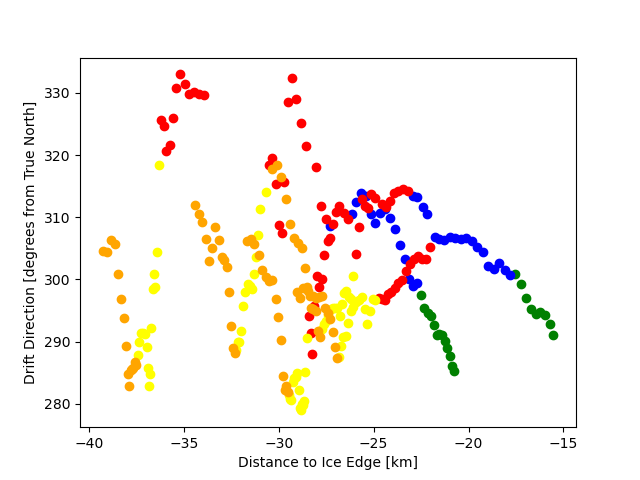

In [11]:
# Plot the drift speed as a function of the distance to ice edge for each day
fig, ax = plt.subplots()
ax.scatter(window1_df['dist_to_ice_edge'], window1_df['drift_direction'], color='green')
ax.scatter(window2_df['dist_to_ice_edge'], window2_df['drift_direction'], color='blue')
ax.scatter(window3_df['dist_to_ice_edge'], window3_df['drift_direction'], color='red')
ax.scatter(window4_df['dist_to_ice_edge'], window4_df['drift_direction'], color='yellow')
ax.scatter(window5_df['dist_to_ice_edge'], window5_df['drift_direction'], color='orange')
ax.set_xlabel('Distance to Ice Edge [km]')
ax.set_ylabel('Drift Direction [degrees from True North]')

In [12]:
# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]


In [13]:
# Find index of closest Ice Map - September 10th 
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])

2022-09-10 00:00:00


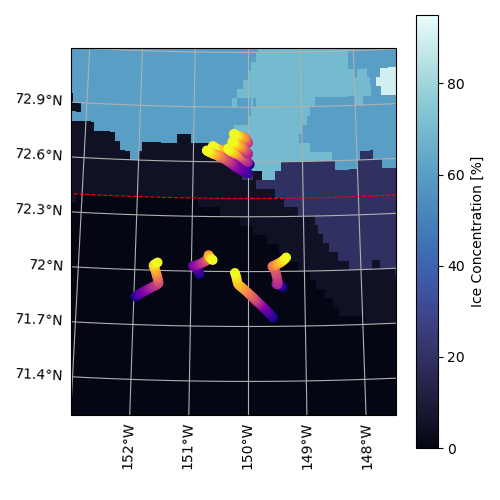

In [14]:
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
ax.scatter(df['longitude'], df['latitude'], c=df['time'], cmap='plasma', transform=cartopy.crs.PlateCarree())

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_map_conc[:,:,ind_for_ice_map],
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

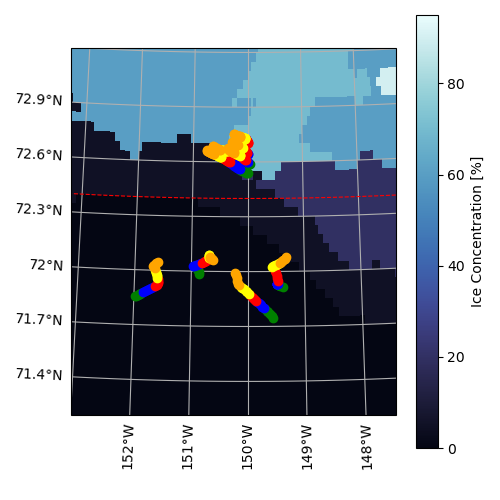

In [15]:
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
ax.scatter(window1_df['longitude'], window1_df['latitude'], color='green', transform=cartopy.crs.PlateCarree())
ax.scatter(window2_df['longitude'], window2_df['latitude'], color='blue', transform=cartopy.crs.PlateCarree())
ax.scatter(window3_df['longitude'], window3_df['latitude'], color='red', transform=cartopy.crs.PlateCarree())
ax.scatter(window4_df['longitude'], window4_df['latitude'], color='yellow', transform=cartopy.crs.PlateCarree())
ax.scatter(window5_df['longitude'], window5_df['latitude'], color='orange', transform=cartopy.crs.PlateCarree())

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_map_conc[:,:,ind_for_ice_map],
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

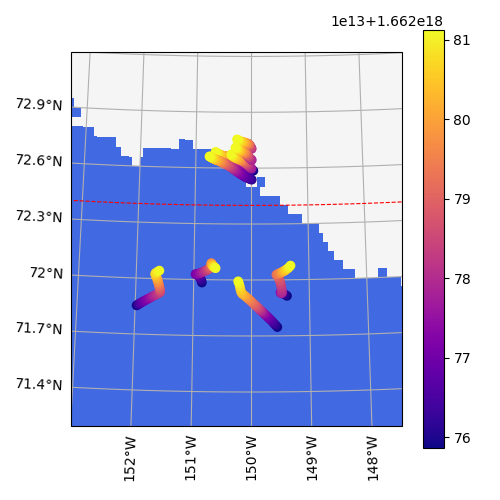

In [16]:
# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_map_conc[:,:,ind_for_ice_map].shape)
ice_conc_15percent[ice_map_conc[:,:,ind_for_ice_map] >= 15] = 1

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c=df['time'], cmap='plasma', transform=cartopy.crs.PlateCarree())
fig.colorbar(im)

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()

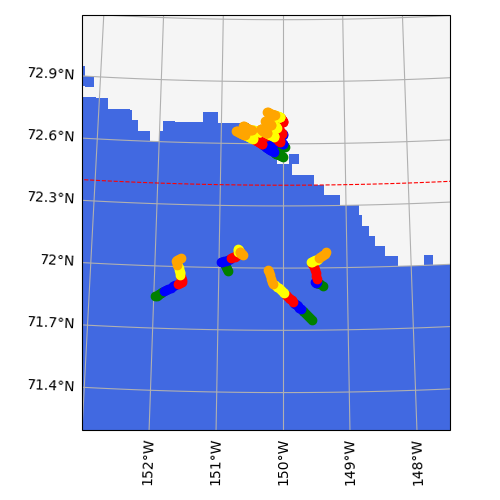

In [26]:
# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_map_conc[:,:,ind_for_ice_map].shape)
ice_conc_15percent[ice_map_conc[:,:,ind_for_ice_map] >= 15] = 1

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Draw approximate ice edge 
ax.gridlines(draw_labels=False, xlocs=[], ylocs=[ice_edge_lat], color='r', linestyle='dashed', label='Approximate Ice Edge')

# Plot locations of SWIFTs and Wavegliders
# Plot locations of SWIFTs and Wavegliders
ax.scatter(window1_df['longitude'], window1_df['latitude'], color='green', transform=cartopy.crs.PlateCarree())
ax.scatter(window2_df['longitude'], window2_df['latitude'], color='blue', transform=cartopy.crs.PlateCarree())
ax.scatter(window3_df['longitude'], window3_df['latitude'], color='red', transform=cartopy.crs.PlateCarree())
ax.scatter(window4_df['longitude'], window4_df['latitude'], color='yellow', transform=cartopy.crs.PlateCarree())
ax.scatter(window5_df['longitude'], window5_df['latitude'], color='orange', transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()

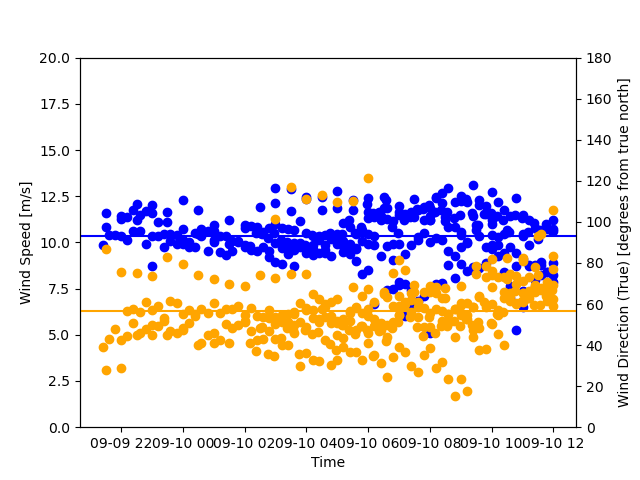

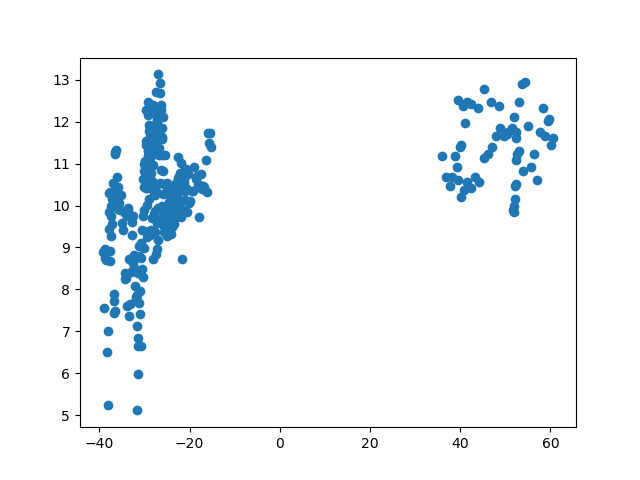

In [17]:
# Plot the wind speed and direction 
fig, ax = plt.subplots()
ax.scatter(df['time'], df['windspd'], color='b')
ax.axhline(np.nanmean(df['windspd']), color='b')
ax2 = ax.twinx()
ax2.scatter(df['time'], df['winddir'], color='orange')
ax2.axhline(np.nanmean(df['winddir']), color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Wind Speed [m/s]')
ax.set_ylim(0, 20)
ax2.set_ylabel('Wind Direction (True) [degrees from true north]')
ax2.set_ylim(0, 180)

fig, ax = plt.subplots()
ax.scatter(df['dist_to_ice_edge'], df['windspd'])

(0.0, 90.0)

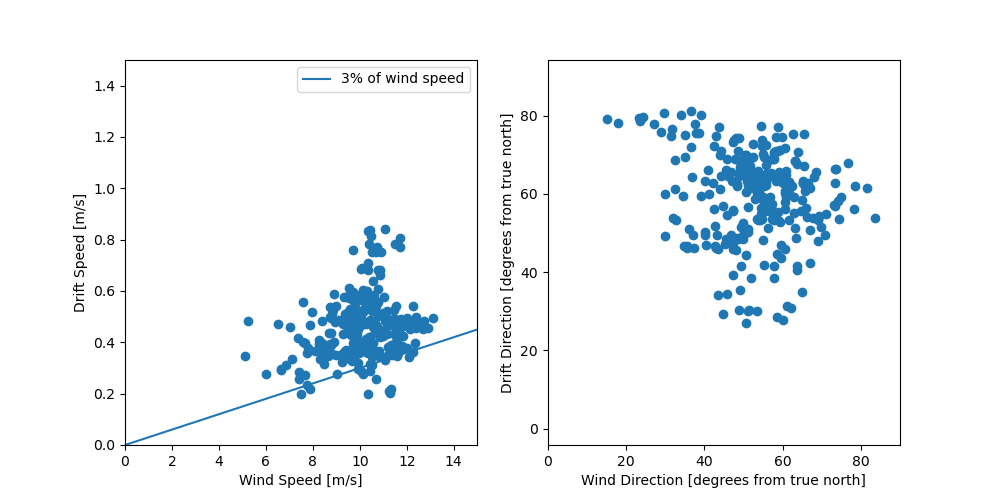

In [18]:
# Regression of Wind Speed and Drift Speed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(df['windspd'], df['drift_speed'])
ax1.plot(np.linspace(0, 15), 0.03*np.linspace(0, 15), label='3% of wind speed')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(0, 15)
ax1.set_xlabel('Wind Speed [m/s]')
ax1.set_ylabel('Drift Speed [m/s]')
ax1.legend()

ax2.scatter(df['winddir'], 360 - df['drift_direction'])
ax2.set_xlabel('Wind Direction [degrees from true north]')
ax2.set_ylabel('Drift Direction [degrees from true north]')
ax2.axis('equal')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 90)

Now lets try applying the same model as used in DUNEX to model the SWIFT trajectory with wind and stokes drift to see how well that model applies. 

Simple Wind Drift Model:
 
$\vec{u} = \vec{u_o} + \gamma \vec{u_a}$

Here, $\vec{u}$ is the velocity of the microSWIFT, $\vec{u_o}$ is the current velocity, and $\vec{u_a}$ is the wind speed. This has been expanded to a 2d vector equation from the 1d analysis completed as a static equilibrium between atmospheric and oceanic forcing on an object. Also, $\gamma$ is the wind sensitivity which we can precisely compute given the dimensions of the microSWIFTs but it is typically ~3%. For this simple model, we will use the 3% wind drift rule and see how the drift tracks differ between the buoys and the modeled trajectory. 

Therefore, the simple wind drift only model to start will be the following, 

$\vec{x} = \gamma \vec{u_a} t$

or 

$x = \gamma {u_x}_a t + x_o = \gamma |u_a|*cos(\theta) t + x_o$

$y = \gamma {u_y}_a t + y_o = \gamma |u_a|*sin(\theta) t + y_o$

In [19]:
# Transform the ice Edge into a local coordinate system
def localCoordinateTransform(lat, lon, lat_0, lon_0, rotation):
    '''
    @edwinrainville

    Description: This function transforms an arbitrary set of lat and lon coordinates from a mission and computes a 
    local coordinate system that has an origin at the mean value of the lat and lon coordinates. This returns the x and
    y values in the new coordinate system. Units are meters from origin.

    '''
    # Make sure that lat and lon are numpy arrays 
    lat = np.array(lat)
    lon = np.array(lon)

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    lon_earth_rad = np.cos(np.deg2rad(np.median(lat)))*earth_rad   

    # Compute Deviations about the lat-lon center in the new cooridnate system
    y = np.empty(lat.shape)
    x = np.empty(lon.shape)
    for n in np.arange(lat.shape[0]):
        y[n] = earth_rad * np.deg2rad(lat_0 - lat[n])
        x[n] = lon_earth_rad * np.deg2rad(lon_0 - lon[n])  

    x = x * np.cos(np.deg2rad(rotation))   -   y * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = x * np.sin(np.deg2rad(rotation))   +   y * np.cos (np.deg2rad(rotation))

    # Return the x and y coordinates 
    return x, y

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30303/3139674732.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swift_df['x'], swift_df['y'] = localCoordinateTransform(swift_df['latitude'], swift_df['longitude'], lat_0, lon_0, rotation)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30303/3139674732.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swift_df['x'], swift_df['y'] = localCoordinateTransform(swift_df['latitude'], swift_df['longitude'], lat_0, lon_0, rotation)


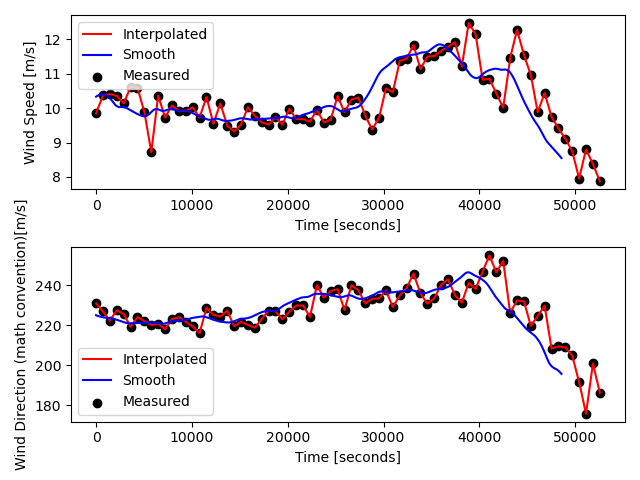

In [20]:
# Compute Wind Sensitivity value for microSWIFT
# wind_sensitivity = 0.03 - this is the membrane solution
wind_sensitivity = 0.03 # Approximated from the analytical solution in Wagner et al 2022 - this is also the best fitting

# Trajectory to model - set as the swift number
trajectory_num = 12
swift_df = df[df['swiftnum'] == trajectory_num]

# Compute time values 
time_seconds_measured = [(swift_df['time'] - swift_df['time'].iloc[0]).iloc[n].total_seconds() for n in range(len(swift_df))]
time_seconds = np.linspace(0, time_seconds_measured[-1], int(time_seconds_measured[-1])+1)

# Transform the swift to local coordinate system 
lat_0 = np.mean(swift_df['latitude'])
lon_0 = np.mean(swift_df['longitude'])
rotation = 0
swift_df['x'], swift_df['y'] = localCoordinateTransform(swift_df['latitude'], swift_df['longitude'], lat_0, lon_0, rotation)

# Interpolate the windspeed, and wind direction
wind_speed_interp = np.interp(time_seconds, time_seconds_measured, swift_df['windspd'])
N = 4000
wind_speed_smooth =  np.convolve(wind_speed_interp, np.ones(N)/N, mode='valid')
wind_direction_interp = np.interp(time_seconds, time_seconds_measured, swift_df['winddir_mathconv'])
wind_direction_smooth =  np.convolve(wind_direction_interp, np.ones(N)/N, mode='valid')

# Plot the interpolated wind speed and direction 
fig, (ax1, ax2)= plt.subplots(nrows=2)
ax1.plot(time_seconds, wind_speed_interp, label='Interpolated', color='r')
ax1.plot(wind_speed_smooth, label='Smooth', color='b')
ax1.scatter(time_seconds_measured, swift_df['windspd'], label='Measured', color='k')
ax1.set_xlabel('Time [seconds]')
ax1.set_ylabel('Wind Speed [m/s]')
ax1.legend()

ax2.plot(time_seconds, wind_direction_interp, label='Interpolated', color='r')
ax2.plot(wind_direction_smooth, label='Smooth', color='b')
ax2.scatter(time_seconds_measured, swift_df['winddir_mathconv'], label='Measured', color='k')
ax2.set_xlabel('Time [seconds]')
ax2.set_ylabel('Wind Direction (math convention)[m/s]')
ax2.legend()
fig.tight_layout()

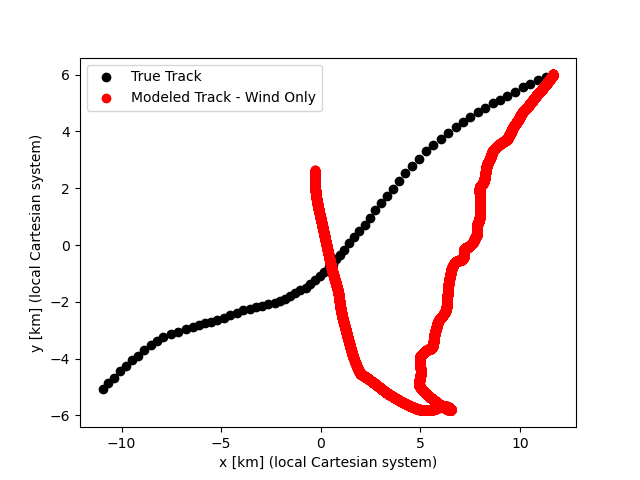

In [21]:
# Compute Wind Only Drift Model
# x_location_modeled = (wind_sensitivity * wind_speed_interp * np.cos(np.deg2rad(wind_direction_interp)) * time_seconds) + swift_df['x'].iloc[0]
# y_location_modeled = (wind_sensitivity * wind_speed_interp * np.sin(np.deg2rad(wind_direction_interp)) * time_seconds) + swift_df['y'].iloc[0]
x_location_modeled = (wind_sensitivity * wind_speed_smooth * np.cos(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size]) + swift_df['x'].iloc[0]
y_location_modeled = (wind_sensitivity * wind_speed_smooth * np.sin(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size]) + swift_df['y'].iloc[0]

# Plot the true and modeled trajectory in local coordinate system
fig, ax = plt.subplots()

# Plot locations of SWIFTs and Wavegliders
ax.scatter(swift_df['x']/1000, swift_df['y']/1000, color='k', label='True Track')
ax.scatter(x_location_modeled/1000 , y_location_modeled/1000, color='r', label='Modeled Track - Wind Only')
ax.set_xlabel('x [km] (local Cartesian system)')
ax.set_ylabel('y [km] (local Cartesian system)')
ax.legend()

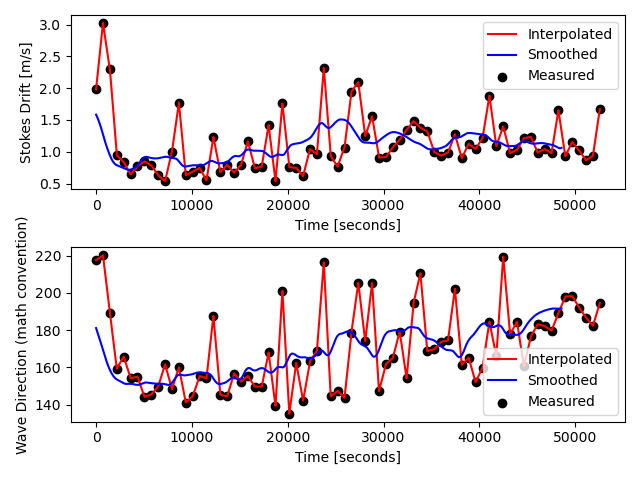

In [22]:
# Get Wave Direction, Height, and Period to compute Stokes drift estimate
g = 9.8 
Tp = swift_df['wave_period']
Hs = swift_df['hs']
stokes_drift = (((2 * np.pi)**3 / g) * Hs**2 / Tp**3)
stokes_drift_interp = np.interp(time_seconds, time_seconds_measured, stokes_drift)
stokes_drift_smooth =  np.convolve(stokes_drift_interp, np.ones(N)/N, mode='valid')
wave_direction = swift_df['wave_direction_mathconv']
wave_direction_interp = np.interp(time_seconds, time_seconds_measured, wave_direction)
wave_direction_smooth =  np.convolve(wave_direction_interp, np.ones(N)/N, mode='valid')

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(time_seconds, stokes_drift_interp, label='Interpolated', color='r')
ax1.plot(stokes_drift_smooth, label='Smoothed', color='b')
ax1.scatter(time_seconds_measured, stokes_drift, label='Measured', color='k')
ax1.set_xlabel('Time [seconds]')
ax1.set_ylabel('Stokes Drift [m/s]')
ax1.legend()

ax2.plot(time_seconds, wave_direction_interp, label='Interpolated', color='r')
ax2.plot(wave_direction_smooth, label='Smoothed', color='b')
ax2.scatter(time_seconds_measured, wave_direction, label='Measured', color='k')
ax2.set_xlabel('Time [seconds]')
ax2.set_ylabel('Wave Direction (math convention)')
ax2.legend()
fig.tight_layout()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30303/3430770253.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


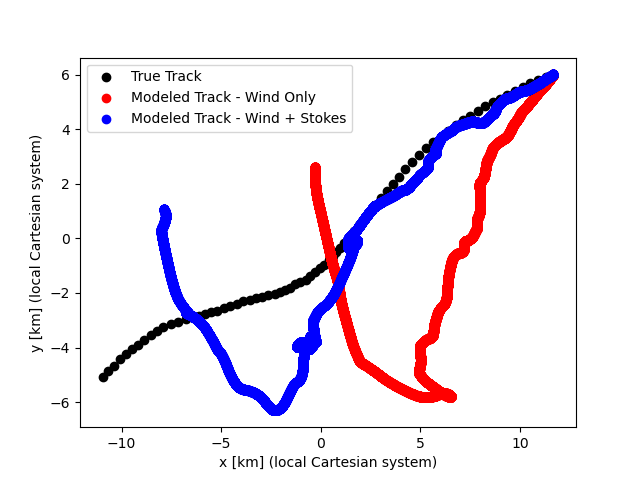

In [23]:
# Compute modeled track - wind only 
# x_location_modeled = (wind_sensitivity * wind_speed_interp * np.cos(np.deg2rad(wind_direction_interp)) * time_seconds) + swift_df['x'].iloc[0]
# y_location_modeled = (wind_sensitivity * wind_speed_interp * np.sin(np.deg2rad(wind_direction_interp)) * time_seconds) + swift_df['y'].iloc[0]
x_location_modeled = (wind_sensitivity * wind_speed_smooth * np.cos(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size]) + swift_df['x'].iloc[0]
y_location_modeled = (wind_sensitivity * wind_speed_smooth * np.sin(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size]) + swift_df['y'].iloc[0]

# Stokes sensitivity 
stokes_sensitivity = 0.15

# Compute Modeled track - wind and stokes
# x_location_modeled_stokes = ((wind_sensitivity * wind_speed_interp * np.cos(np.deg2rad(wind_direction_interp)) * time_seconds)
#                              + stokes_sensitivity * stokes_drift_interp * np.cos(np.deg2rad(wave_direction_interp)) * time_seconds
#                              + swift_df['x'].iloc[0]) 
# y_location_modeled_stokes = ((wind_sensitivity * wind_speed_interp * np.sin(np.deg2rad(wind_direction_interp)) * time_seconds)
#                              + stokes_sensitivity * stokes_drift_interp * np.sin(np.deg2rad(wave_direction_interp)) * time_seconds
#                              + swift_df['y'].iloc[0]) 
x_location_modeled_stokes = ((wind_sensitivity * wind_speed_smooth * np.cos(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size])
                             + stokes_sensitivity * stokes_drift_smooth * np.cos(np.deg2rad(wave_direction_smooth)) * time_seconds[:wind_speed_smooth.size]
                             + swift_df['x'].iloc[0]) 
y_location_modeled_stokes = ((wind_sensitivity * wind_speed_smooth * np.sin(np.deg2rad(wind_direction_smooth)) * time_seconds[:wind_speed_smooth.size])
                             + stokes_sensitivity * stokes_drift_smooth * np.sin(np.deg2rad(wave_direction_smooth)) * time_seconds[:wind_speed_smooth.size]
                             + swift_df['y'].iloc[0]) 

# Plot the true and modeled trajectory in local coordinate system
fig, ax = plt.subplots()

# Plot locations of SWIFTs and Wavegliders
ax.scatter(swift_df['x']/1000, swift_df['y']/1000, color='k', label='True Track')
ax.scatter(x_location_modeled/1000 , y_location_modeled/1000, color='r', label='Modeled Track - Wind Only')
ax.scatter(x_location_modeled_stokes/1000 , y_location_modeled_stokes/1000, color='b', label='Modeled Track - Wind + Stokes')
ax.set_xlabel('x [km] (local Cartesian system)')
ax.set_ylabel('y [km] (local Cartesian system)')
ax.legend()

In [24]:
swift_df

,time,latitude,longitude,hs,wave_direction,wave_direction_mathconv,drift_speed,drift_direction,instrument_type,dist_to_ice_edge,windspd,winddir,swiftnum,winddir_mathconv,wave_period,x,y
0,2022-09-09 21:24:00.000004,72.586037,-149.964966,0.815253,52.389679,217.610321,NaN,NaN,SWIFT,-20.650072,9.851455,39.118851,12.0,230.881149,2.039841,11680.511771,6006.182549
1,2022-09-09 21:36:00.000002,72.587006,-149.976730,0.939075,49.847000,220.153000,0.554840,285.247159,SWIFT,-20.757623,10.378298,43.066589,12.0,226.933411,1.946768,11289.957511,5898.322035
2,2022-09-09 21:48:00.000000,72.587936,-149.988266,0.945042,80.848877,189.151123,0.554722,286.136217,SWIFT,-20.860941,10.409463,47.654869,12.0,222.345131,2.142259,10907.001583,5794.707998
3,2022-09-09 21:59:59.999996,72.589012,-149.999924,0.934823,110.630768,159.369232,0.565919,287.676971,SWIFT,-20.980348,10.356704,42.467369,12.0,227.532631,2.860335,10519.993211,5674.957348
4,2022-09-09 22:12:00.000004,72.590172,-150.011734,0.977387,104.254364,165.745636,0.581481,289.020320,SWIFT,-21.109071,10.136875,44.359627,12.0,225.640373,3.065868,10127.919284,5545.864449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2022-09-10 11:12:00.000000,72.678146,-150.611404,1.211247,71.698242,198.301758,0.494582,301.533480,SWIFT,-30.874246,8.751711,65.019836,12.0,204.980164,3.180124,-9779.710322,-4247.360663
70,2022-09-10 11:23:59.999998,72.679855,-150.620651,1.077896,77.845581,192.154419,0.517925,303.878425,SWIFT,-31.063943,7.952425,78.224236,12.0,191.775764,3.065868,-10086.682932,-4437.602830
71,2022-09-10 11:35:59.999996,72.681892,-150.630112,1.048609,83.296783,186.703217,0.510604,305.646483,SWIFT,-31.290056,8.802011,94.147751,12.0,175.852249,3.180124,-10400.747317,-4664.364699
72,2022-09-10 11:48:00.000002,72.683716,-150.638702,1.089568,87.707611,182.292389,0.481715,306.569644,SWIFT,-31.492456,8.383011,69.031784,12.0,200.968216,3.180124,-10685.938042,-4867.346296
